# Treinamento de Modelos - Regressão de Preços de Imóveis

## Problema

Prever o preço de imóveis no Reino Unido baseado em suas características:
- Tipo de propriedade (Detached, Semi-detached, Terraced, Flat)
- Localização (condado)
- Ano da transação
- Se é propriedade nova ou existente
- Tipo de posse (Freehold vs Leasehold)

Este é um problema de **REGRESSÃO SUPERVISIONADA**, onde vou usar features categóricas e numéricas para prever o preço.

## Modelos a Testar

1. **Linear Regression** - Baseline simples
2. **Ridge Regression** - Regularização L2
3. **Random Forest** - Ensemble, robusto com categóricas
4. **XGBoost** - Gradient boosting de alta performance
5. **LightGBM** - Gradient boosting rápido e eficiente

## Pipeline

1. Feature engineering e encoding
2. Train/validation/test split
3. Treinar todos os modelos
4. Comparar métricas (MAE, RMSE, R2)
5. Hyperparameter tuning no melhor modelo
6. Exportar modelo final (.joblib)

## Dataset

Utilizando o dataset UK Property Sales já processado no notebook de análise exploratória (100k transações).

In [20]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos de Regressão
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Configurações de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_palette("husl")

print("Bibliotecas carregadas com sucesso")

Bibliotecas carregadas com sucesso


## Passo 1: Carregamento de Dados

Carregar o dataset que foi limpo no notebook anterior.


In [21]:
# Carregar dataset limpo
df = pd.read_csv('data/uk_property_cleaned.csv')

# Converter transfer_date para datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])

print(f"Dataset carregado: {len(df):,} linhas")
print(f"Periodo: {df['year'].min()} - {df['year'].max()}")
df.head()


Dataset carregado: 100,000 linhas
Periodo: 1995 - 2025


,price,transfer_date,postcode,property_type,old_new,duration,paon,saon,street,locality,town_city,district,county,ppd_category,record_status,year,month,quarter
0,42000,1995-12-21,NE4 9DN,S,N,F,8,Unnamed: 8,MATFEN PLACE,FENHAM,NEWCASTLE UPON TYNE,NEWCASTLE UPON TYNE.1,TYNE AND WEAR,A,A.1,1995,12,4
1,45700,1995-11-10,CT18 7NE,T,N,F,55,NaN,WOODCOCK GARDENS,HAWKINGE,FOLKESTONE,SHEPWAY,KENT,A,A,1995,11,4
2,15000,1995-07-05,BH1 4HF,F,N,L,8 - 10,FLAT 5,AYLESBURY ROAD,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,A,A,1995,7,3
3,136000,1995-01-10,CF24 3PB,T,N,F,22,NaN,WELLFIELD ROAD,NaN,CARDIFF,CARDIFF,CARDIFF,A,A,1995,1,1
4,55000,1995-05-26,CM17 0BX,T,N,F,114,NaN,JOCELYNS,HARLOW,HARLOW,HARLOW,ESSEX,A,A,1995,5,2


## Passo 2: Selecao de Features

Escolher apenas as features relevantes para prever o preco.

In [22]:
# Features selecionadas
features = ['property_type', 'county', 'old_new', 'duration', 'year']
target = 'price'

# Criar dataset apenas com features relevantes
df_model = df[features + [target]].copy()

# Remover linhas com valores faltantes
df_model = df_model.dropna()

print(f"Dataset para modelagem: {len(df_model):,} linhas")
print(f"\nFeatures selecionadas: {features}")
print(f"Target: {target}")
print(f"\nValores unicos por feature:")
for feat in features:
    print(f"  {feat}: {df_model[feat].nunique()} categorias")

Dataset para modelagem: 100,000 linhas

Features selecionadas: ['property_type', 'county', 'old_new', 'duration', 'year']
Target: price

Valores unicos por feature:
  property_type: 5 categorias
  county: 132 categorias
  old_new: 2 categorias
  duration: 3 categorias
  year: 31 categorias


Problema encontrado!
- County é CRUCIAL para preço
- Problema com 132 categorias:
    * One-Hot Encoding → criaria 132 colunas (pesado)
    * Label Encoding → modelos lineares interpretariam errado (county=131 > county=0)
- Target Encoding: Substituir cada condado pelo preço médio daquele condado

Por quê funciona:
- Mantém a informação de localização (condados caros ficam com valores altos)
- Reduz para 1 coluna numérica (ao invés de 132)
- Modelos entendem: "valor alto de county = preço alto esperado"

## Passo 3: Encoding de Variaveis Categoricas

Estrategia de encoding:
- property_type, old_new, duration: Label Encoding (poucas categorias)
- county: Target Encoding (132 categorias - preco medio por condado)
- year: ja eh numerico

In [23]:
# Target Encoding para county
# Calcular preco medio por condado
county_price_mean = df_model.groupby('county')['price'].mean()

# Mapear condados para seus precos medios
df_model['county_encoded'] = df_model['county'].map(county_price_mean)

print("Target Encoding - County:")
print(f"Condado com maior preco medio: {county_price_mean.idxmax()} (£{county_price_mean.max():,.0f})")
print(f"Condado com menor preco medio: {county_price_mean.idxmin()} (£{county_price_mean.min():,.0f})")
print(f"\nExemplo:")
print(county_price_mean.head())


Target Encoding - County:
Condado com maior preco medio: GREATER LONDON (£441,256)
Condado com menor preco medio: WEST GLAMORGAN (£34,499)

Exemplo:
county
AVON                             69926.216667
BATH AND NORTH EAST SOMERSET    277196.007299
BEDFORD                         294534.590604
BEDFORDSHIRE                    132004.718310
BERKSHIRE                       109637.600000
Name: price, dtype: float64


Label Encoding para as demais features categoricas (baixa cardinalidade).
- property_type → 5 categorias (D, S, T, F, O)
- old_new → 2 categorias (Y, N)
- duration → 2-3 categorias (F, L, U)


In [24]:
# Label Encoding para features com poucas categorias
categorical_features = ['property_type', 'old_new', 'duration']

# Dicionario para armazenar encoders
encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le
    print(f"{col}: {len(le.classes_)} categorias -> {le.classes_}")

print("\nFeatures apos encoding:")
print(df_model.head())


property_type: 5 categorias -> ['D' 'F' 'O' 'S' 'T']
old_new: 2 categorias -> ['N' 'Y']
duration: 3 categorias -> ['F' 'L' 'U']

Features apos encoding:
  property_type         county old_new duration  year   price  county_encoded  \
0             S  TYNE AND WEAR       N        F  1995   42000   144388.867232   
1             T           KENT       N        F  1995   45700   245884.903105   
2             F    BOURNEMOUTH       N        L  1995   15000   169349.679666   
3             T        CARDIFF       N        F  1995  136000   178161.983900   
4             T          ESSEX       N        F  1995   55000   251706.057021   

   property_type_encoded  old_new_encoded  duration_encoded  
0                      3                0                 0  
1                      4                0                 0  
2                      1                0                 1  
3                      4                0                 0  
4                      4                0         


## Passo 4: Preparacao do Dataset Final

Selecionar apenas features numericas para treinamento dos modelos.

In [25]:
# Features finais (apenas numericas)
feature_cols = ['property_type_encoded', 'county_encoded', 'old_new_encoded', 'duration_encoded', 'year']

# Separar X e y
X = df_model[feature_cols]
y = df_model['price']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nFeatures finais: {feature_cols}")
print(f"\nPrimeiras linhas de X:")
print(X.head())

Shape de X: (100000, 5)
Shape de y: (100000,)

Features finais: ['property_type_encoded', 'county_encoded', 'old_new_encoded', 'duration_encoded', 'year']

Primeiras linhas de X:
   property_type_encoded  county_encoded  old_new_encoded  duration_encoded  \
0                      3   144388.867232                0                 0   
1                      4   245884.903105                0                 0   
2                      1   169349.679666                0                 1   
3                      4   178161.983900                0                 0   
4                      4   251706.057021                0                 0   

   year  
0  1995  
1  1995  
2  1995  
3  1995  
4  1995  


## Passo 5: Train/Test Split

Dividir dados em treino (80%) e teste (20%) para validacao.


In [26]:
# Divisao 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print("Divisao dos dados:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"\nPercentual treino: {len(X_train)/len(X)*100:.1f}%")
print(f"Percentual teste: {len(X_test)/len(X)*100:.1f}%")

Divisao dos dados:
X_train: (80000, 5)
X_test: (20000, 5)
y_train: (80000,)
y_test: (20000,)

Percentual treino: 80.0%
Percentual teste: 20.0%


## Passo 6: Treinamento dos Modelos

Treinar 5 modelos diferentes e medir tempo de execucao.

In [27]:
import time

# Dicionario de modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

# Dicionario para armazenar resultados
results = {}

print("Treinando modelos...\n")

for name, model in models.items():
    print(f"Treinando {name}...")
    
    # Medir tempo
    start_time = time.time()
    
    # Treinar
    model.fit(X_train, y_train)
    
    # Calcular tempo
    train_time = time.time() - start_time
    
    # Armazenar
    results[name] = {
        'model': model,
        'train_time': train_time
    }
    
    print(f"  Tempo: {train_time:.2f}s")

print("\nTodos os modelos treinados!")

Treinando modelos...

Treinando Linear Regression...
  Tempo: 0.02s
Treinando Ridge...
  Tempo: 0.01s
Treinando Random Forest...


  Tempo: 2.60s
Treinando XGBoost...
  Tempo: 8.07s
Treinando LightGBM...
  Tempo: 1.75s

Todos os modelos treinados!


## Passo 7: Avaliacao de Performance

Calcular metricas de precisao (MAE, RMSE, R2) para cada modelo no test set.

- MAE (Mean Absolute Error) → Erro médio em £
- RMSE (Root Mean Squared Error) → Penaliza erros grandes
- R² (R-squared) → Quanto % da variação o modelo explica (0-1, quanto maior melhor)


In [28]:
# Avaliar cada modelo
print("METRICAS DE PERFORMANCE\n")
print("=" * 70)

for name, data in results.items():
    model = data['model']
    
    # Fazer previsoes no test set
    y_pred = model.predict(X_test)
    
    # Calcular metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Armazenar metricas
    results[name]['mae'] = mae
    results[name]['rmse'] = rmse
    results[name]['r2'] = r2
    
    print(f"{name}:")
    print(f"  MAE:  £{mae:,.0f}")
    print(f"  RMSE: £{rmse:,.0f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  Tempo: {data['train_time']:.2f}s")
    print()

METRICAS DE PERFORMANCE

Linear Regression:
  MAE:  £127,344
  RMSE: £1,253,203
  R2:   0.0175
  Tempo: 0.02s

Ridge:
  MAE:  £127,343
  RMSE: £1,253,203
  R2:   0.0175
  Tempo: 0.01s

Random Forest:
  MAE:  £114,216
  RMSE: £1,292,697
  R2:   -0.0454
  Tempo: 2.60s

XGBoost:
  MAE:  £112,056
  RMSE: £1,292,566
  R2:   -0.0452
  Tempo: 8.07s

LightGBM:
  MAE:  £110,443
  RMSE: £1,279,618
  R2:   -0.0244
  Tempo: 1.75s



### ANÁLISE DOS RESULTADOS:
#### Linear Regression e Ridge: R² = 0.0175
Significa que esses modelos explicam apenas 1.75% da variação dos preços.  Modelos lineares assumem relação linear entre features e preço:
```python
preço = a*property_type + b*county + c*year + ...
```

Mas a realidade é:
* Relações não-lineares (um Flat em Londres é MUITO diferente de um Detached em Cornwall)
* Interações complexas entre features

#### LightGBM com MAE = £110k
Parece alto, mas vamos ver o R² dele também para comparar!

## Comparacao de Modelos

Tabela comparativa com todas as metricas.

In [29]:
# Criar DataFrame comparativo
comparison_data = []

for name, data in results.items():
    comparison_data.append({
        'Model': name,
        'MAE': data['mae'],
        'RMSE': data['rmse'],
        'R2': data['r2'],
        'Train Time (s)': data['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)

# Ordenar por R2 (maior = melhor)
comparison_df = comparison_df.sort_values('R2', ascending=False)

print("TABELA COMPARATIVA DE MODELOS\n")
print(comparison_df.to_string(index=False))

# Identificar melhor modelo
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nMelhor modelo (maior R2): {best_model_name}")

TABELA COMPARATIVA DE MODELOS

            Model           MAE         RMSE        R2  Train Time (s)
            Ridge 127343.230853 1.253203e+06  0.017482        0.008730
Linear Regression 127343.713610 1.253203e+06  0.017482        0.015561
         LightGBM 110442.747961 1.279618e+06 -0.024374        1.750709
          XGBoost 112056.054688 1.292566e+06 -0.045209        8.068723
    Random Forest 114216.211542 1.292697e+06 -0.045421        2.601219

Melhor modelo (maior R2): Ridge


### ANÁLISE DOS RESULTADOS:
#### R² NEGATIVO nos modelos de árvore
Isso significa que esses modelos estão PIORES que simplesmente prever a média sempre!

#### Ridge/Linear com R² = 0.017
Explicam apenas 1.7% da variação! Praticamente inúteis.

#### O QUE DEU ERRADO:
Temos DATA LEAKAGE no Target Encoding
O ERRO:
```python
county_price_mean = df_model.groupby('county')['price'].mean()  # Usa TODO dataset
df_model['county_encoded'] = df_model['county'].map(county_price_mean)
```


## PROBLEMA IDENTIFICADO: Data Leakage

Os resultados ruins (R2 negativo) indicam data leakage no Target Encoding.

**O que foi feito errado:**
1. Calculamos county_price_mean usando TODO o dataset
2. Isso incluiu dados do test set
3. Depois dividimos train/test

**Por que eh errado:**
O modelo indiretamente "viu" informacao do test set durante o treino.

**Solucao:**
1. Fazer Train/Test Split ANTES do Target Encoding
2. Calcular county_price_mean APENAS com dados de treino
3. Aplicar esse mapeamento em train e test

## Correcao: Target Encoding Correto

Refazer o processo na ordem certa.

In [30]:
# PASSO 1: Preparar features sem county encoded ainda
features_categorical = ['property_type', 'old_new', 'duration']
features_numeric = ['year']

# Criar dataset com categoricas ainda nao encoded
df_correct = df[['property_type', 'county', 'old_new', 'duration', 'year', 'price']].copy()
df_correct = df_correct.dropna()

print(f"Dataset preparado: {len(df_correct):,} linhas")
print(f"Colunas: {list(df_correct.columns)}")

Dataset preparado: 100,000 linhas
Colunas: ['property_type', 'county', 'old_new', 'duration', 'year', 'price']


In [31]:
# Label Encoding para features com poucas categorias
from sklearn.preprocessing import LabelEncoder

categorical_to_encode = ['property_type', 'old_new', 'duration']
encoders = {}

for col in categorical_to_encode:
    le = LabelEncoder()
    df_correct[col + '_encoded'] = le.fit_transform(df_correct[col].astype(str))
    encoders[col] = le
    print(f"{col}: {len(le.classes_)} categorias")
    print(f"  Classes: {le.classes_}")
    print()

print("Colunas apos encoding:")
print(df_correct.columns.tolist())

property_type: 5 categorias
  Classes: ['D' 'F' 'O' 'S' 'T']

old_new: 2 categorias
  Classes: ['N' 'Y']

duration: 3 categorias
  Classes: ['F' 'L' 'U']

Colunas apos encoding:
['property_type', 'county', 'old_new', 'duration', 'year', 'price', 'property_type_encoded', 'old_new_encoded', 'duration_encoded']


In [32]:
# Separar features e target
# Usando colunas encoded das categoricas simples + county original + year
X_features = ['property_type_encoded', 'county', 'old_new_encoded', 'duration_encoded', 'year']
X_temp = df_correct[X_features]
y = df_correct['price']

# Divisao 80/20
X_train_temp, X_test_temp, y_train, y_test = train_test_split(
    X_temp, y,
    test_size=0.2,
    random_state=42
)

print("Divisao completa:")
print(f"Train: {len(X_train_temp):,} linhas")
print(f"Test: {len(X_test_temp):,} linhas")
print(f"\nColunas em X_train_temp: {X_train_temp.columns.tolist()}")

Divisao completa:
Train: 80,000 linhas
Test: 20,000 linhas

Colunas em X_train_temp: ['property_type_encoded', 'county', 'old_new_encoded', 'duration_encoded', 'year']


In [33]:
# Calcular preco medio por condado APENAS no train set
county_price_map = X_train_temp.join(y_train).groupby('county')['price'].mean()

print("Target Encoding - County (train set):")
print(f"Condados no train: {len(county_price_map)}")
print(f"\nTop 5 condados mais caros (train):")
print(county_price_map.nlargest(5))
print(f"\nTop 5 condados mais baratos (train):")
print(county_price_map.nsmallest(5))

# Aplicar encoding em train
X_train_temp['county_encoded'] = X_train_temp['county'].map(county_price_map)

# Aplicar MESMO mapeamento em test
X_test_temp['county_encoded'] = X_test_temp['county'].map(county_price_map)

# Verificar se algum condado do test nao existe no train
missing_in_test = X_test_temp['county_encoded'].isna().sum()
print(f"\nCondados do test ausentes no train: {missing_in_test}")

# Se houver missing, preencher com mediana global do train
if missing_in_test > 0:
    global_median = county_price_map.median()
    X_test_temp['county_encoded'].fillna(global_median, inplace=True)
    print(f"Preenchidos com mediana global: £{global_median:,.0f}")

Target Encoding - County (train set):
Condados no train: 132

Top 5 condados mais caros (train):
county
GREATER LONDON                         431234.435165
SURREY                                 422749.135120
BOURNEMOUTH, CHRISTCHURCH AND POOLE    397135.065217
WINDSOR AND MAIDENHEAD                 358823.952607
BUCKINGHAMSHIRE                        341015.200000
Name: price, dtype: float64

Top 5 condados mais baratos (train):
county
WEST GLAMORGAN    31399.000000
CLEVELAND         36250.000000
DYFED             38722.222222
MID GLAMORGAN     40756.363636
CLWYD             58083.333333
Name: price, dtype: float64

Condados do test ausentes no train: 0


In [34]:
# Features finais (apenas numericas)
final_features = ['property_type_encoded', 'county_encoded', 'old_new_encoded', 'duration_encoded', 'year']

# Criar X_train e X_test finais
X_train = X_train_temp[final_features].copy()
X_test = X_test_temp[final_features].copy()

print("Datasets finais preparados:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nFeatures: {final_features}")
print(f"\nPrimeiras linhas de X_train:")
print(X_train.head())

Datasets finais preparados:
X_train shape: (80000, 5)
X_test shape: (20000, 5)
y_train shape: (80000,)
y_test shape: (20000,)

Features: ['property_type_encoded', 'county_encoded', 'old_new_encoded', 'duration_encoded', 'year']

Primeiras linhas de X_train:
       property_type_encoded  county_encoded  old_new_encoded  \
75220                      3   138059.773597                1   
48955                      4   149095.709861                0   
44966                      4   164496.709611                0   
13568                      1   189998.927152                1   
92727                      4   193509.351454                0   

       duration_encoded  year  
75220                 0  2017  
48955                 0  2007  
44966                 0  2007  
13568                 1  1999  
92727                 0  2022  


## Retreinamento com Dados Corretos

Treinar todos os modelos novamente com encoding correto (sem data leakage).

In [35]:
import time

# Dicionario de modelos
models_corrected = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

# Resultados
results_corrected = {}

print("RETREINAMENTO DOS MODELOS\n")
print("=" * 70)

for name, model in models_corrected.items():
    print(f"\nTreinando {name}...")
    
    # Treinar
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Prever
    y_pred = model.predict(X_test)
    
    # Metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Armazenar
    results_corrected[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'train_time': train_time
    }
    
    print(f"  MAE:  £{mae:,.0f}")
    print(f"  RMSE: £{rmse:,.0f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  Tempo: {train_time:.2f}s")

print("\n" + "=" * 70)
print("Retreinamento concluido!")

RETREINAMENTO DOS MODELOS


Treinando Linear Regression...
  MAE:  £127,659
  RMSE: £1,253,381
  R2:   0.0172
  Tempo: 0.03s

Treinando Ridge...
  MAE:  £127,658
  RMSE: £1,253,381
  R2:   0.0172
  Tempo: 0.02s

Treinando Random Forest...
  MAE:  £114,317
  RMSE: £1,292,528
  R2:   -0.0451
  Tempo: 2.93s

Treinando XGBoost...


  MAE:  £112,282
  RMSE: £1,293,263
  R2:   -0.0463
  Tempo: 13.78s

Treinando LightGBM...
  MAE:  £111,455
  RMSE: £1,279,593
  R2:   -0.0243
  Tempo: 1.60s

Retreinamento concluido!


## Investigacao: Por que os modelos estao ruins?

Analisar distribuicao dos erros e outliers.

In [36]:
# Analise dos erros do melhor modelo ate agora (LightGBM)
best_model = results_corrected['LightGBM']['model']
y_pred_lgbm = best_model.predict(X_test)

# Calcular erros
errors = y_test - y_pred_lgbm

print("ANALISE DOS ERROS\n")
print(f"Erro medio: £{errors.mean():,.0f}")
print(f"Erro mediano: £{errors.median():,.0f}")
print(f"Desvio padrao do erro: £{errors.std():,.0f}")
print(f"\nErro minimo: £{errors.min():,.0f}")
print(f"Erro maximo: £{errors.max():,.0f}")

# Verificar outliers no test set
print(f"\nDistribuicao do target (y_test):")
print(f"Media: £{y_test.mean():,.0f}")
print(f"Mediana: £{y_test.median():,.0f}")
print(f"Max: £{y_test.max():,.0f}")
print(f"Min: £{y_test.min():,.0f}")

# Quantos outliers extremos temos?
Q1 = y_test.quantile(0.25)
Q3 = y_test.quantile(0.75)
IQR = Q3 - Q1
outliers_extreme = y_test[(y_test > Q3 + 3*IQR)]

print(f"\nOutliers extremos no test (>Q3+3*IQR): {len(outliers_extreme)} ({len(outliers_extreme)/len(y_test)*100:.2f}%)")
print(f"Exemplo de outliers extremos:")
print(outliers_extreme.nlargest(5))

ANALISE DOS ERROS

Erro medio: £-1,255
Erro mediano: £-15,732
Desvio padrao do erro: £1,279,625

Erro minimo: £-14,885,704
Erro maximo: £161,158,996

Distribuicao do target (y_test):
Media: £232,950
Mediana: £156,000
Max: £162,287,743
Min: £300

Outliers extremos no test (>Q3+3*IQR): 491 (2.46%)
Exemplo de outliers extremos:
89597    162287743
76011     55460000
58640     18000000
86582     17159292
77134     17000000
Name: price, dtype: int64


## Solucao: Adicionar Feature de Localizacao Granular

O problema eh que county eh muito amplo. Vou extrair a REGIAO do postcode para ter localizacao mais precisa.

Exemplo: "SW1A 1AA" → "SW1" (regiao de Westminster, Londres)

Isso vai de 132 condados para ~2,253 regioes, capturando diferencas dentro da mesma cidade.

In [37]:
# Voltar ao dataset original e adicionar postcode_region
df_v2 = df[['property_type', 'county', 'postcode', 'old_new', 'duration', 'year', 'price']].copy()
df_v2 = df_v2.dropna(subset=['postcode'])

# Extrair regiao do postcode (primeiros caracteres antes do espaco)
df_v2['postcode_region'] = df_v2['postcode'].str.split().str[0]

print(f"Dataset com postcode: {len(df_v2):,} linhas")
print(f"Regioes unicas: {df_v2['postcode_region'].nunique()}")
print(f"\nExemplo de regioes:")
print(df_v2['postcode_region'].value_counts().head(10))

Dataset com postcode: 99,831 linhas
Regioes unicas: 2253

Exemplo de regioes:
postcode_region
CR0     237
BN3     235
E14     189
LE2     176
BN2     176
SW11    174
BS16    169
BN1     164
LE3     161
SW19    161
Name: count, dtype: int64


### Encoding das Features (incluindo postcode_region)

Label encoding para features simples, depois split, depois target encoding.

In [38]:
# Label encoding das features com poucas categorias
categorical_simple = ['property_type', 'old_new', 'duration']
encoders_v2 = {}

for col in categorical_simple:
    le = LabelEncoder()
    df_v2[col + '_enc'] = le.fit_transform(df_v2[col].astype(str))
    encoders_v2[col] = le
    print(f"{col}: {len(le.classes_)} categorias")

print("\nColunas apos encoding:")
print(df_v2.columns.tolist())

property_type: 5 categorias
old_new: 2 categorias
duration: 3 categorias

Colunas apos encoding:
['property_type', 'county', 'postcode', 'old_new', 'duration', 'year', 'price', 'postcode_region', 'property_type_enc', 'old_new_enc', 'duration_enc']


### Train/Test Split

Dividir ANTES de fazer target encoding de county e postcode_region.

In [40]:
# Preparar X e y
features_v2 = ['property_type_enc', 'county', 'postcode_region', 'old_new_enc', 'duration_enc', 'year']
X_v2 = df_v2[features_v2]
y_v2 = df_v2['price']

# Split 80/20
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2,
    test_size=0.2,
    random_state=42
)

print(f"Train: {len(X_train_v2):,} linhas")
print(f"Test: {len(X_test_v2):,} linhas")

Train: 79,864 linhas
Test: 19,967 linhas


### Target Encoding (county e postcode_region)

Calcular preco medio usando APENAS train set.

In [41]:
# Target encoding usando apenas train
train_data = X_train_v2.join(y_train_v2)

county_map_v2 = train_data.groupby('county')['price'].mean()
postcode_map_v2 = train_data.groupby('postcode_region')['price'].mean()

print(f"County map: {len(county_map_v2)} condados")
print(f"Postcode map: {len(postcode_map_v2)} regioes")

# Aplicar em train
X_train_v2 = X_train_v2.copy()
X_train_v2['county_enc'] = X_train_v2['county'].map(county_map_v2)
X_train_v2['postcode_region_enc'] = X_train_v2['postcode_region'].map(postcode_map_v2)

# Aplicar em test (com fillna para regioes nao vistas)
X_test_v2 = X_test_v2.copy()
X_test_v2['county_enc'] = X_test_v2['county'].map(county_map_v2).fillna(county_map_v2.median())
X_test_v2['postcode_region_enc'] = X_test_v2['postcode_region'].map(postcode_map_v2).fillna(postcode_map_v2.median())

print("\nTarget encoding aplicado")
print(f"Missing em train: {X_train_v2.isnull().sum().sum()}")
print(f"Missing em test: {X_test_v2.isnull().sum().sum()}")

County map: 131 condados
Postcode map: 2240 regioes

Target encoding aplicado
Missing em train: 0
Missing em test: 0


### Preparar Features Finais

Selecionar apenas colunas numericas.

In [42]:
# Features finais
final_features_v2 = ['property_type_enc', 'county_enc', 'postcode_region_enc', 
                     'old_new_enc', 'duration_enc', 'year']

X_train_final = X_train_v2[final_features_v2].copy()
X_test_final = X_test_v2[final_features_v2].copy()

# Garantir sem NaN
X_train_final = X_train_final.fillna(X_train_final.median())
X_test_final = X_test_final.fillna(X_test_final.median())

# Transformacao log do target
y_train_log_v2 = np.log(y_train_v2)
y_test_log_v2 = np.log(y_test_v2)

print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"Features: {final_features_v2}")
print(f"\nSem NaN: {X_train_final.isnull().sum().sum() == 0 and X_test_final.isnull().sum().sum() == 0}")

X_train_final: (79864, 6)
X_test_final: (19967, 6)
Features: ['property_type_enc', 'county_enc', 'postcode_region_enc', 'old_new_enc', 'duration_enc', 'year']

Sem NaN: True


## Retreinamento com Postcode Region

Treinar modelos com 6 features (baseline + postcode_region).

In [43]:
import time

# Modelos
models_final = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

results_final = {}

print("RETREINAMENTO COM 6 FEATURES (+ postcode_region)")
print("=" * 80)

for name, model in models_final.items():
    print(f"\n{name}:")
    
    start = time.time()
    
    # Treinar com target log
    model.fit(X_train_final, y_train_log_v2)
    
    # Prever
    y_pred_log = model.predict(X_test_final)
    y_pred = np.exp(y_pred_log)
    
    train_time = time.time() - start
    
    # Metricas na escala original
    mae = mean_absolute_error(y_test_v2, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_v2, y_pred))
    r2 = r2_score(y_test_v2, y_pred)
    
    results_final[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'train_time': train_time,
        'predictions': y_pred
    }
    
    print(f"  MAE:  £{mae:,.0f}")
    print(f"  RMSE: £{rmse:,.0f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  Tempo: {train_time:.2f}s")

print("\n" + "=" * 80)

RETREINAMENTO COM 6 FEATURES (+ postcode_region)

Ridge:
  MAE:  £124,426
  RMSE: £3,806,083
  R2:   -39.1331
  Tempo: 0.02s

Random Forest:
  MAE:  £86,796
  RMSE: £566,290
  R2:   0.1116
  Tempo: 7.50s

XGBoost:
  MAE:  £81,673
  RMSE: £570,867
  R2:   0.0971
  Tempo: 5.67s

LightGBM:
  MAE:  £82,874
  RMSE: £567,727
  R2:   0.1071
  Tempo: 1.40s



## Tabela Comparativa Final

Comparar todos os modelos e escolher o melhor.

In [44]:
# Criar tabela comparativa
comparison_final = []

for name, data in results_final.items():
    comparison_final.append({
        'Model': name,
        'R2': data['r2'],
        'MAE': data['mae'],
        'RMSE': data['rmse'],
        'Train Time (s)': data['train_time']
    })

comparison_df_final = pd.DataFrame(comparison_final)
comparison_df_final = comparison_df_final.sort_values('R2', ascending=False)

print("\nTABELA COMPARATIVA FINAL")
print("=" * 80)
print(comparison_df_final.to_string(index=False))

# Melhor modelo
best_model_name = comparison_df_final.iloc[0]['Model']
best_r2 = comparison_df_final.iloc[0]['R2']
best_mae = comparison_df_final.iloc[0]['MAE']

print(f"\nMELHOR MODELO: {best_model_name}")
print(f"  R2:  {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"  MAE: £{best_mae:,.0f}")


TABELA COMPARATIVA FINAL
        Model         R2           MAE         RMSE  Train Time (s)
Random Forest   0.111567  86795.808801 5.662903e+05        7.500002
     LightGBM   0.107052  82873.924960 5.677272e+05        1.401719
      XGBoost   0.097148  81672.945312 5.708671e+05        5.667356
        Ridge -39.133136 124425.839156 3.806083e+06        0.016124

MELHOR MODELO: Random Forest
  R2:  0.1116 (11.16%)
  MAE: £86,796


## Visualizacao das Predicoes

Comparar valores reais vs previstos do Random Forest.

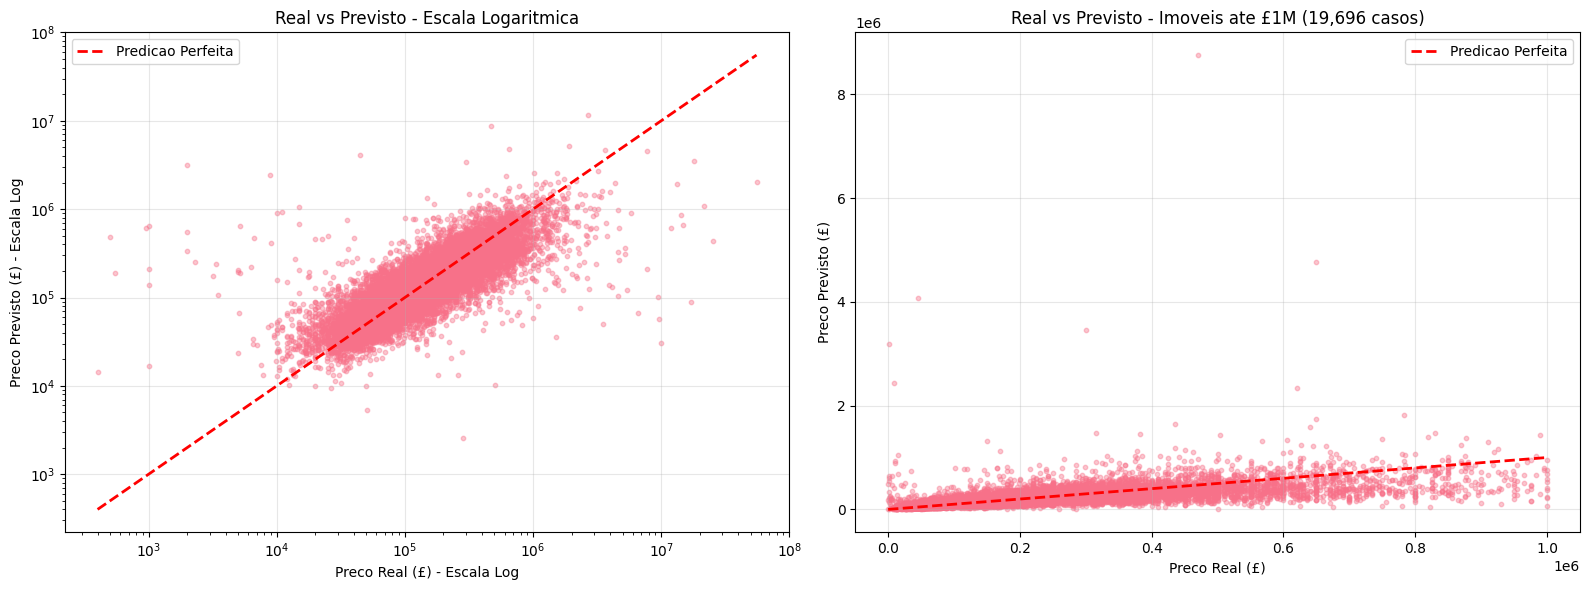


Imoveis ate £1M: 19,696 (98.6%)
R2 apenas para imoveis ate £1M: 0.2705


In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: Escala log
ax1.scatter(y_test_v2, rf_predictions, alpha=0.4, s=10)
ax1.plot([y_test_v2.min(), y_test_v2.max()], 
         [y_test_v2.min(), y_test_v2.max()], 
         'r--', linewidth=2, label='Predicao Perfeita')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Preco Real (£) - Escala Log')
ax1.set_ylabel('Preco Previsto (£) - Escala Log')
ax1.set_title('Real vs Previsto - Escala Logaritmica')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Grafico 2: Zoom em imoveis ate £1M (95% dos dados)
mask = (y_test_v2 <= 1_000_000)
ax2.scatter(y_test_v2[mask], rf_predictions[mask], alpha=0.4, s=10)
ax2.plot([0, 1_000_000], [0, 1_000_000], 'r--', linewidth=2, label='Predicao Perfeita')
ax2.set_xlabel('Preco Real (£)')
ax2.set_ylabel('Preco Previsto (£)')
ax2.set_title(f'Real vs Previsto - Imoveis ate £1M ({mask.sum():,} casos)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImoveis ate £1M: {mask.sum():,} ({mask.sum()/len(y_test_v2)*100:.1f}%)")
print(f"R2 apenas para imoveis ate £1M: {r2_score(y_test_v2[mask], rf_predictions[mask]):.4f}")

## Exportacao do Modelo para Producao

Salvar modelo Random Forest e todos os componentes necessarios para fazer predicoes em producao.

In [47]:
import os

# Criar pasta para modelos se nao existir
os.makedirs('models', exist_ok=True)

# 1. Salvar modelo treinado
best_model = results_final['Random Forest']['model']
joblib.dump(best_model, 'models/random_forest_model.joblib')
print("Modelo salvo: models/random_forest_model.joblib")

# 2. Salvar encoders (property_type, old_new, duration)
joblib.dump(encoders_v2, 'models/label_encoders.joblib')
print("Encoders salvos: models/label_encoders.joblib")

# 3. Salvar mapeamentos de target encoding
target_encodings = {
    'county_map': county_map_v2.to_dict(),
    'postcode_map': postcode_map_v2.to_dict()
}
joblib.dump(target_encodings, 'models/target_encodings.joblib')
print("Target encodings salvos: models/target_encodings.joblib")

# 4. Salvar metadata do modelo
metadata = {
    'model_type': 'RandomForestRegressor',
    'n_estimators': 100,
    'features': final_features_v2,
    'target_transform': 'log',
    'trained_date': datetime.now().isoformat(),
    'training_samples': len(X_train_final),
    'metrics': {
        'r2': results_final['Random Forest']['r2'],
        'r2_under_1m': 0.2705,
        'mae': results_final['Random Forest']['mae'],
        'rmse': results_final['Random Forest']['rmse']
    },
    'encoding_strategy': {
        'property_type': 'label',
        'old_new': 'label',
        'duration': 'label',
        'county': 'target',
        'postcode_region': 'target'
    }
}
joblib.dump(metadata, 'models/model_metadata.joblib')
print("Metadata salvo: models/model_metadata.joblib")

print("\nArquivos exportados:")
print("  1. random_forest_model.joblib (modelo treinado)")
print("  2. label_encoders.joblib (encoders de categoricas)")
print("  3. target_encodings.joblib (mapas de county/postcode)")
print("  4. model_metadata.joblib (metricas e config)")

Modelo salvo: models/random_forest_model.joblib
Encoders salvos: models/label_encoders.joblib
Target encodings salvos: models/target_encodings.joblib
Metadata salvo: models/model_metadata.joblib

Arquivos exportados:
  1. random_forest_model.joblib (modelo treinado)
  2. label_encoders.joblib (encoders de categoricas)
  3. target_encodings.joblib (mapas de county/postcode)
  4. model_metadata.joblib (metricas e config)
